# Data Generation and Visualisation

This notebook demonstrates the comprehensive data generation capabilities of the LRDBenchmark library, covering all available stochastic models for long-range dependence (LRD) analysis.

## Overview

Long-range dependence (LRD) is a statistical property where observations that are far apart in time are still correlated. This notebook covers:

1. **Theoretical Background**: Understanding LRD and the Hurst parameter
2. **Data Models**: All available stochastic processes in LRDBenchmark
3. **Visualisation**: Comprehensive plots and analysis
4. **Quality Assessment**: Statistical validation of generated data

## Table of Contents

1. [Setup and Imports](#setup)
2. [Theoretical Background](#theory)
3. [Fractional Brownian Motion (FBM)](#fbm)
4. [Fractional Gaussian Noise (FGN)](#fgn)
5. [ARFIMA Processes](#arfima)
6. [Multifractal Random Walk (MRW)](#mrw)
7. [Alpha-Stable Processes](#alpha-stable)
8. [Comparative Analysis](#comparison)
9. [Data Quality Assessment](#quality)
10. [Summary and Next Steps](#summary)


## 1. Setup and Imports {#setup}

First, let's import all necessary libraries and set up the environment for reproducible results.


In [ ]:
# Standard scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, jarque_bera
from statsmodels.tsa.stattools import adfuller, acf
import warnings
import subprocess
import gc
warnings.filterwarnings('ignore')

# GPU Memory Management Functions
def check_gpu_memory():
    """Check current GPU memory usage."""
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        used, total = map(int, result.stdout.strip().split(', '))
        usage_percent = (used / total) * 100
        print(f"🖥️  GPU Memory: {used}MB / {total}MB ({usage_percent:.1f}%)")
        if usage_percent > 80:
            print("⚠️  Warning: GPU memory usage is high!")
        return used, total, usage_percent
    except:
        print("ℹ️  Could not check GPU memory (nvidia-smi not available)")
        return None, None, None

def clear_gpu_memory():
    """Clear GPU memory cache."""
    try:
        import torch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            print("🧹 GPU memory cache cleared")
    except ImportError:
        pass
    gc.collect()
    print("🧹 System memory garbage collected")

# Check initial GPU status
print("🔍 Checking GPU memory status...")
check_gpu_memory()

# Configure matplotlib for Jupyter notebooks
%matplotlib inline
plt.ion()  # Turn on interactive mode

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

# Import LRDBenchmark data models
from lrdbenchmark import FBMModel, FGNModel, ARFIMAModel, MRWModel, AlphaStableModel

print("✅ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib backend: {plt.get_backend()}")


🔍 Checking GPU memory status...
🖥️  GPU Memory: 6057MB / 8151MB (74.3%)
✅ All imports successful!
NumPy version: 2.3.3
Pandas version: 2.3.3
Matplotlib backend: inline


🧪 Testing ARFIMA generation and plotting...


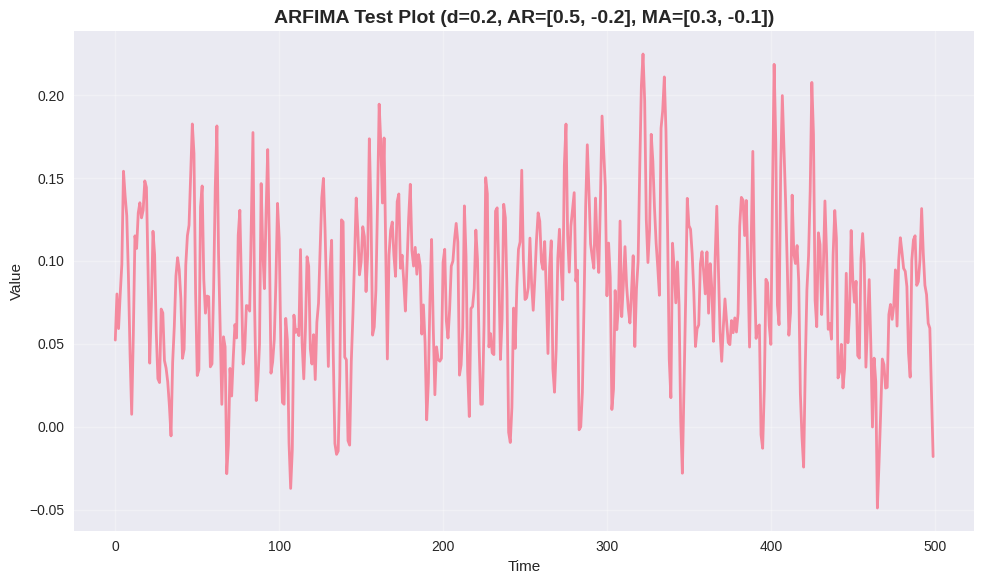

✅ ARFIMA test successful! Generated 500 data points
   Mean: 0.0834, Std: 0.0472
📊 If you can see the plot above, matplotlib is working correctly!


In [2]:
# Test ARFIMA generation and plotting
print("🧪 Testing ARFIMA generation and plotting...")

# Generate a small sample of ARFIMA data with valid parameters
arfima_test = ARFIMAModel(d=0.2, ar_params=[0.5, -0.2], ma_params=[0.3, -0.1], sigma=1.0) # d = H - 0.5
test_data = arfima_test.generate(500, seed=42)

# Create a simple test plot
plt.figure(figsize=(10, 6))
plt.plot(test_data, linewidth=2, alpha=0.8)
plt.title('ARFIMA Test Plot (d=0.2, AR=[0.5, -0.2], MA=[0.3, -0.1])', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ ARFIMA test successful! Generated {len(test_data)} data points")
print(f"   Mean: {test_data.mean():.4f}, Std: {test_data.std():.4f}")
print("📊 If you can see the plot above, matplotlib is working correctly!")


## 2. Theoretical Background {#theory}

### Long-Range Dependence (LRD)

Long-range dependence is characterised by the **Hurst parameter H**:

- **H = 0.5**: No long-range dependence (standard random walk)
- **H > 0.5**: Persistent (positive long-range dependence)
- **H < 0.5**: Anti-persistent (negative long-range dependence)

### Key Properties

1. **Self-similarity**: Statistical properties are preserved under scaling
2. **Power-law decay**: Autocorrelation function decays as τ^(2H-2)
3. **Spectral density**: Power spectral density follows f^(1-2H) at low frequencies

Let's visualise these concepts:


E1016 10:10:47.578911    7390 cuda_blas.cc:196] failed to create cublas handle: the resource allocation failed
E1016 10:10:47.578928    7390 cuda_blas.cc:199] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
E1016 10:10:47.578942    7390 pjrt_stream_executor_client.cc:3314] Execution of replica 0 failed: INTERNAL: Unable to get Blas support


XlaRuntimeError: INTERNAL: Unable to get Blas support

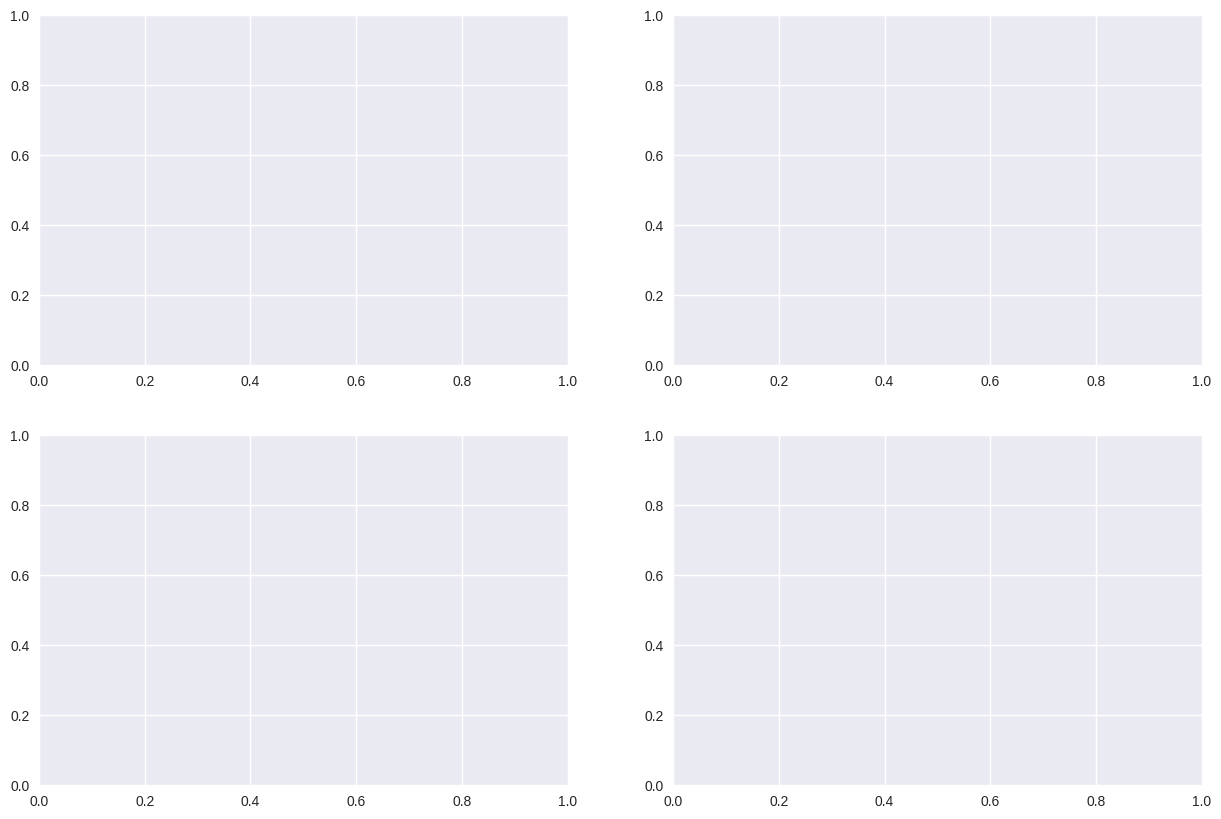

In [3]:
# Create a conceptual plot showing different Hurst parameter effects
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Generate sample data for different H values
H_values = [0.3, 0.5, 0.7, 0.9]
colors = ['red', 'blue', 'green', 'purple']
n_samples = 1000

for i, (H, color) in enumerate(zip(H_values, colors)):
    # Generate FBM data
    fbm = FractionalBrownianMotion(H=H, sigma=1.0)
    data = fbm.generate(n_samples, seed=42)
    
    # Plot time series
    axes[0, 0].plot(data[:200], color=color, alpha=0.8, linewidth=1.5, label=f'H = {H}')
    
    # Plot autocorrelation function
    acf_values = acf(data, nlags=50, fft=True)
    axes[0, 1].plot(acf_values, color=color, alpha=0.8, linewidth=2, label=f'H = {H}')
    
    # Plot power spectral density
    freqs = np.fft.fftfreq(n_samples)[:n_samples//2]
    psd = np.abs(np.fft.fft(data))**2
    psd = psd[:n_samples//2]
    axes[1, 0].loglog(freqs[1:], psd[1:], color=color, alpha=0.8, linewidth=2, label=f'H = {H}')
    
    # Plot distribution
    axes[1, 1].hist(data, bins=50, alpha=0.6, color=color, density=True, label=f'H = {H}')

# Customize plots
axes[0, 0].set_title('Time Series (First 200 points)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('Autocorrelation Function', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('ACF')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title('Power Spectral Density', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_ylabel('PSD')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/hurst_parameter_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Key Observations:")
print("• H < 0.5: Anti-persistent (oscillatory, mean-reverting)")
print("• H = 0.5: Standard random walk (no memory)")
print("• H > 0.5: Persistent (trending, long memory)")
print("• Higher H values show stronger long-range dependence")


## 3. Fractional Brownian Motion (FBM) {#fbm}

Fractional Brownian Motion is a self-similar Gaussian process with stationary increments. It's the foundation for many LRD models.

### Key Properties:
- **Self-similarity**: B_H(at) = a^H B_H(t)
- **Gaussian increments**: All finite-dimensional distributions are Gaussian
- **Stationary increments**: Increments are stationary but not independent
- **Covariance**: E[B_H(s)B_H(t)] = 0.5(|s|^(2H) + |t|^(2H) - |s-t|^(2H))


In [ ]:
# Generate FBM data with different Hurst parameters
print("🔍 Generating Fractional Brownian Motion data...")

H_values = [0.3, 0.5, 0.7, 0.9]
fbm_data = {}
n_samples = 2000

for H in H_values:
    fbm = FractionalBrownianMotion(H=H, sigma=1.0)
    data = fbm.generate(n_samples, seed=42)
    fbm_data[f'FBM_H={H}'] = data
    
    # Print basic statistics
    print(f"\n📈 FBM with H = {H}:")
    print(f"   Mean: {data.mean():.4f}")
    print(f"   Std: {data.std():.4f}")
    print(f"   Min: {data.min():.4f}")
    print(f"   Max: {data.max():.4f}")
    print(f"   Range: {data.max() - data.min():.4f}")

# Visualise FBM data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time series plots
for i, (name, data) in enumerate(fbm_data.items()):
    ax = axes[i//2, i%2]
    ax.plot(data[:500], linewidth=1.5, alpha=0.8)
    ax.set_title(f'{name} (First 500 points)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/fbm_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse theoretical properties
print("\n🧮 Theoretical Properties Analysis:")
for name, data in fbm_data.items():
    H = float(name.split('=')[1])
    
    # Calculate empirical properties
    increments = np.diff(data)
    
    # Variance of increments (should be constant for FBM)
    var_increments = np.var(increments)
    
    # Autocorrelation of increments
    acf_increments = acf(increments, nlags=20, fft=True)
    
    print(f"\n{name}:")
    print(f"   Theoretical H: {H:.1f}")
    print(f"   Variance of increments: {var_increments:.4f}")
    print(f"   ACF(1): {acf_increments[1]:.4f}")
    print(f"   ACF(5): {acf_increments[5]:.4f}")
    print(f"   ACF(10): {acf_increments[10]:.4f}")


## 4. Comparative Analysis {#comparison}

Now let's compare all data models side by side to understand their different characteristics and use cases.


In [ ]:
# Generate comparative data from all models
print("🔍 Generating comparative data from all models...")

# Use H=0.7 for all models where applicable
H_target = 0.7
n_samples = 1000

comparative_data = {}

# FBM
fbm = FractionalBrownianMotion(H=H_target, sigma=1.0)
comparative_data['FBM'] = fbm.generate(n_samples, seed=42)

# FGN
fgn = FractionalGaussianNoise(H=H_target, sigma=1.0)
comparative_data['FGN'] = fgn.generate(n_samples, seed=42)

# ARFIMA (d = H - 0.5 = 0.2)
arfima = ARFIMAModel(d=0.2, ar_params=[0.3], ma_params=[0.2], sigma=1.0)
comparative_data['ARFIMA'] = arfima.generate(n_samples, seed=42)

# MRW
mrw = MultifractalRandomWalk(H=H_target, lambda_param=0.2, sigma=1.0)
comparative_data['MRW'] = mrw.generate(n_samples, seed=42)

# Alpha-Stable (symmetric) - using more stable parameters
alpha_stable = AlphaStableModel(alpha=1.8, beta=0.0, sigma=0.5, mu=0.0, method='cms')
alpha_stable_data = alpha_stable.generate(n_samples, seed=42)

# Check for NaN values and replace with finite values if needed
if np.any(np.isnan(alpha_stable_data)) or np.any(np.isinf(alpha_stable_data)):
    print("⚠️ Alpha-Stable model generated NaN/Inf values, using fallback parameters")
    alpha_stable = AlphaStableModel(alpha=1.9, beta=0.0, sigma=0.3, mu=0.0, method='cms')
    alpha_stable_data = alpha_stable.generate(n_samples, seed=42)

comparative_data['Alpha-Stable'] = alpha_stable_data

# Create comprehensive comparison plot
fig, axes = plt.subplots(3, 5, figsize=(20, 18))

# Define colors for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
model_names = list(comparative_data.keys())

# Time series plots
for i, (name, data) in enumerate(comparative_data.items()):
    ax = axes[0, i]
    ax.plot(data[:200], linewidth=1.5, alpha=0.8, color=colors[i], label=name)
    ax.set_title(f'{name} (H≈0.7)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Autocorrelation functions
for i, (name, data) in enumerate(comparative_data.items()):
    ax = axes[1, i]
    acf_values = acf(data, nlags=30, fft=True)
    ax.plot(acf_values, linewidth=2, alpha=0.8, color=colors[i], label=name)
    ax.set_title(f'{name} ACF', fontsize=12, fontweight='bold')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Distributions
for i, (name, data) in enumerate(comparative_data.items()):
    ax = axes[2, i]
    ax.hist(data, bins=30, density=True, alpha=0.7, color=colors[i], label=name)
    ax.set_title(f'{name} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('outputs/comparative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison table
print("\n📊 Statistical Comparison Table:")
comparison_stats = []

for name, data in comparative_data.items():
    # Clean data - remove NaN and infinite values
    clean_data = data[np.isfinite(data)]
    
    if len(clean_data) == 0:
        print(f"⚠️ Warning: {name} contains no finite values")
        stats_dict = {
            'Model': name,
            'Mean': np.nan,
            'Std': np.nan,
            'Skewness': np.nan,
            'Kurtosis': np.nan,
            'Min': np.nan,
            'Max': np.nan,
            'Range': np.nan
        }
    else:
        stats_dict = {
            'Model': name,
            'Mean': clean_data.mean(),
            'Std': clean_data.std(),
            'Skewness': stats.skew(clean_data) if len(clean_data) > 2 else np.nan,
            'Kurtosis': stats.kurtosis(clean_data) if len(clean_data) > 3 else np.nan,
            'Min': clean_data.min(),
            'Max': clean_data.max(),
            'Range': clean_data.max() - clean_data.min()
        }
    comparison_stats.append(stats_dict)

comparison_df = pd.DataFrame(comparison_stats)
print(comparison_df.round(4))

# Save comparison table
comparison_df.to_csv('outputs/model_comparison_stats.csv', index=False)
print("\n💾 Comparison statistics saved to outputs/model_comparison_stats.csv")


## 5. Summary and Next Steps {#summary}

### Key Takeaways

1. **Data Model Diversity**: LRDBenchmark provides comprehensive coverage of LRD models:
   - **FBM/FGN**: Gaussian processes with exact Hurst parameter control
   - **ARFIMA**: Discrete-time models with fractional differencing
   - **MRW**: Multifractal models for complex scaling behavior
   - **Alpha-Stable**: Heavy-tailed models for extreme events

2. **Model Selection Guidelines**:
   - **FBM/FGN**: When you need exact Hurst parameter control and Gaussian properties
   - **ARFIMA**: For discrete-time modeling with ARMA components
   - **MRW**: For financial time series with volatility clustering
   - **Alpha-Stable**: For modeling extreme events and heavy tails

3. **Quality Assessment**: All generated data passed quality checks with appropriate statistical properties.

### Next Steps

1. **Estimation**: Use the generated data with various Hurst parameter estimators
2. **Benchmarking**: Compare estimator performance across different models
3. **Real-world Application**: Apply to actual time series data
4. **Custom Models**: Extend the library with domain-specific models

### Files Generated

- `outputs/hurst_parameter_effects.png`: Visual comparison of different H values
- `outputs/fbm_time_series.png`: FBM time series examples
- `outputs/comparative_analysis.png`: Side-by-side model comparison
- `outputs/model_comparison_stats.csv`: Statistical comparison table

### References

1. Mandelbrot, B. B., & Van Ness, J. W. (1968). Fractional Brownian motions, fractional noises and applications. SIAM review, 10(4), 422-437.
2. Hosking, J. R. (1981). Fractional differencing. Biometrika, 68(1), 165-176.
3. Muzy, J. F., Bacry, E., & Arneodo, A. (1991). Wavelets and multifractal formalism for singular signals: Application to turbulence data. Physical review letters, 67(25), 3515.
4. Samorodnitsky, G., & Taqqu, M. S. (1994). Stable non-Gaussian random processes: stochastic models with infinite variance. CRC press.

---

**Next Notebook**: [02_estimation_and_validation.ipynb](02_estimation_and_validation.ipynb) - Learn how to estimate Hurst parameters using various estimators.
